In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nm

# Part a

In [2]:
def prepare_data(chosenspecies):
    df = pd.read_csv('F:/Uni/991/Pattern/SPR_HW3/SPR_HW3/inputs/P6/penguins.csv')
    df = df.loc[:,['bill_length_mm', 'bill_depth_mm', 'species']]
    df = df.fillna(df.mean())
    df = df.sample(frac=1 ,replace=False, axis = 0).reset_index(drop=True)
    df_train = df.iloc[:300]
    df_test = df.iloc[300:]
    df_train1 = pd.concat([df_train[df_train['species']==chosenspecies[1]], df_train[df_train['species']==chosenspecies[0]]]).reset_index(drop=True)
    df_train1 = pd.concat([pd.DataFrame({'x0':np.ones((df_train1.shape[0]))}), df_train1], axis=1)
    df_train1 = df_train1.sample(frac=1 ,replace=False, axis = 0).reset_index(drop=True)
    df_test1 = pd.concat([df_test[df_test['species']==chosenspecies[1]], df_test[df_test['species']==chosenspecies[0]]]).reset_index(drop=True)
    df_test1 = pd.concat([pd.DataFrame({'x0':np.ones((df_test1.shape[0]))}), df_test1], axis=1)
    df_test1 = df_test1.sample(frac=1 ,replace=False, axis = 0).reset_index(drop=True)
    for i in range(df_train1.shape[0]):
        if df_train1.loc[i,'species'] == chosenspecies[1]:
            df_train1.loc[i, 'x0']*=-1
            df_train1.loc[i, 'bill_length_mm']*=-1
            df_train1.loc[i, 'bill_depth_mm']*=-1
    for j in range(df_test1.shape[0]):
        if df_test1.loc[j,'species'] == chosenspecies[1]:
            df_test1.loc[j, 'x0']*=-1
            df_test1.loc[j, 'bill_length_mm']*=-1
            df_test1.loc[j, 'bill_depth_mm']*=-1
    x_train1 = np.array(df_train1.drop(columns='species'))
    y_train1 = np.array(df_train1['species'].mask(df_train1['species']==chosenspecies[0], 1).mask(df_train1['species']==chosenspecies[1], -1))
    y_train1 = np.expand_dims(y_train1, axis=1)
    x_test1 = np.array(df_test1.drop(columns='species'))
    y_test1 = np.array(df_test1['species'].mask(df_test1['species']==chosenspecies[0], 1).mask(df_test1['species']==chosenspecies[1], -1))
    y_test1 = np.expand_dims(y_test1, axis=1)
    return x_train1, y_train1, x_test1, y_test1, df_train1, df_test1

In [3]:
def Normalize(x):
    norm_x = np.ones((x.shape[0], x.shape[1]))
    for i in range(1,x.shape[1]):
        min_x = np.amin(x[:,i])
        max_x = np.amax(x[:,i])
        norm_x[:,i] = (x[:,i] - min_x)/(max_x - min_x)
    return norm_x

In [4]:
def ComputeCost(y, h_of_x):
    mse = (1/y.shape[0]) * np.sum(np.power(h_of_x - y, 2))
    return mse

In [5]:
def ComputeHypothesis(data, theta):
    h_of_x = np.ones((data.shape[0], 1))
    for i in range(0,data.shape[0]):
        h_of_x[i] = np.dot(np.transpose(theta), np.expand_dims(data[i,:], axis=1))
    return h_of_x

In [6]:
def GradientDescent(y, data, num_iter, alpha):
    theta = np.ones((data.shape[1], 1))
    mselist = np.zeros(num_iter)
    h_of_x = ComputeHypothesis(data, theta)
    theta_per_iter = np.ones((num_iter, theta.shape[0], theta.shape[1]))
    for i in range(num_iter):
        for j in range(0, data.shape[1]):
            theta[j,0] = theta[j,0] - ((alpha/data.shape[0])* (np.sum(np.dot(np.transpose(h_of_x - 1),np.expand_dims(data[:,j], axis=1)))))
        h_of_x = ComputeHypothesis(data, theta)
        mselist[i] = ComputeCost(y, h_of_x)
        theta_per_iter[i,:,:]=theta
    return theta, mselist, theta_per_iter

In [7]:
def NewtonsMethod(y, data, num_iter):
    theta = np.ones((data.shape[1], 1))
    mselist = np.zeros(num_iter)
    h_of_x = ComputeHypothesis(data, theta)
    theta_per_iter = np.ones((num_iter, theta.shape[0], theta.shape[1]))
    hs = nm.Hessian(lambda t1,t2,t3 : np.sum(((t1*data[:,0])+(t2*data[:,1])+(t3*data[:,2])-1)**2))
    for i in range(num_iter):
        for j in range(0, data.shape[1]):
            theta[j,0] = theta[j,0] - ((np.linalg.inv(hs(theta[0], theta[1], theta[2]))/data.shape[0])* (np.sum(np.dot(np.transpose(h_of_x - 1),np.expand_dims(data[:,j], axis=1)))))
        h_of_x = ComputeHypothesis(data, theta)
        mselist[i] = ComputeCost(y, h_of_x)
        theta_per_iter[i,:,:]=theta
    return theta, mselist, theta_per_iter

In [8]:
def Train(alpha, num_iter, x, y, method):
    x = Normalize(x)
    if method=='gradientdescent':
        theta, mselist, theta_per_iter = GradientDescent(y, x, num_iter, alpha)
    else:
        theta, mselist, theta_per_iter = NewtonsMethod(y, x, num_iter)
    h_of_x = ComputeHypothesis(x, theta)
    mse = ComputeCost(y, h_of_x)
    print("Theta: ", theta)
    print("Train Mean Squared Error: ", mse)
    return theta, h_of_x, mse, mselist, theta_per_iter

In [9]:
def accuracy(y_true, y_pred):
    correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] == y_pred[i]:
            correct += 1
    return correct / y_true.shape[0]


In [10]:
def Predict( x, theta):
    x = Normalize(x)
    h_of_x_p = ComputeHypothesis(x, theta)
    y_pred = np.copy(h_of_x_p)
    for i in range(len(y_pred)):
        if y_pred[i] > 1:
            y_pred[i] = 1
        elif y_pred[i] <= 1:
            y_pred[i] = -1
    return h_of_x_p, y_pred

In [11]:
alpha = 0.1
num_iter = 500
chosen = ['Gentoo', 'Adelie']
x_train1, y_train1, x_test1, y_test1, df_train1, df_test1 = prepare_data(chosen)

In [12]:
theta1, h_of_x1, mse1, mselist1, theta_per_iter1 = Train(alpha, num_iter, x_train1, y_train1, 'gradientdescent')
h_of_x_p1, y_pred1 = Predict( x_test1, theta1)
mse1 = ComputeCost(y_test1, h_of_x_p1)
acc1 = accuracy(y_test1, y_pred1)
print("Test Mean Squared Error: ", mse1)
print("Test Accuracy: ", acc1)

Theta:  [[ 1.00007724]
 [ 0.00860324]
 [-0.00844733]]
Train Mean Squared Error:  2.33468348743862
Test Mean Squared Error:  1.1615464813050504
Test Accuracy:  0.22580645161290322


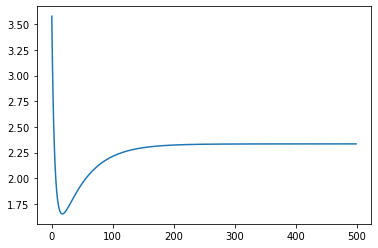

In [13]:
plt.plot(np.arange(num_iter),mselist1)

In [14]:
adelie = df_train1.loc[df_train1['species']=='Adelie',['bill_length_mm',  'bill_depth_mm']].reset_index(drop=True)
gentoo = df_train1.loc[df_train1['species']=='Gentoo',['bill_length_mm',  'bill_depth_mm']].reset_index(drop=True)

In [15]:
index1 = np.where(mselist1==np.min(mselist1))[0]
print(mselist1[np.where(mselist1==np.min(mselist1))])
print(index1[0])
best_theta1 = theta_per_iter1[index1[0]]

[1.65348051]
17


In [16]:
print(best_theta1)

[[0.59102189]
 [0.42504251]
 [0.41100999]]


In [17]:
h_of_x_p1, y_pred1 = Predict( x_test1, best_theta1)
mse1 = ComputeCost(y_test1, h_of_x_p1)
acc1 = accuracy(y_test1, y_pred1)
print("Test Mean Squared Error: ", mse1)
print("Test Accuracy: ", acc1)

Test Mean Squared Error:  0.8412184564255221
Test Accuracy:  1.0


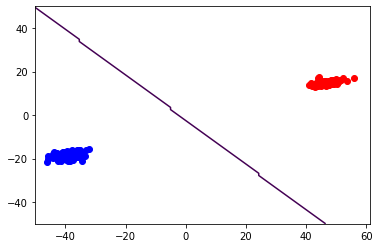

In [18]:
xlist = np.linspace(-50.0, 50.0, 100)
ylist = np.linspace(-50.0, 50.0, 100)
X, Y = np.meshgrid(xlist, ylist)
xplot = np.append(np.expand_dims(np.ones(X.ravel().shape),axis=1),np.expand_dims(X.ravel(),axis=1), axis=1)
xplot = np.append(xplot,np.expand_dims(Y.ravel(), axis=1), axis=1)
Z = Predict(xplot,best_theta1)
plt.contour(X,Y,Z[1].reshape(X.shape), levels=[0])
plt.scatter(gentoo.iloc[:,0], gentoo.iloc[:,1],color='red')
plt.scatter(adelie.iloc[:,0], adelie.iloc[:,1],color='blue')

In [19]:
theta2, h_of_x2, mse2, mselist2, theta_per_iter2 = Train(0, num_iter, x_train1, y_train1, 'newtonsmethod')
h_of_x_p2, y_pred2 = Predict( x_test1, theta2)
mse2 = ComputeCost(y_test1, h_of_x_p2)
acc2 = accuracy(y_test1, y_pred2)
print("Test Mean Squared Error: ", mse2)
print("Test Accuracy: ", acc2)

Theta:  [[0.61020646]
 [0.57047823]
 [0.55918126]]
Train Mean Squared Error:  1.8588529748781764
Test Mean Squared Error:  1.0717056217096361
Test Accuracy:  1.0


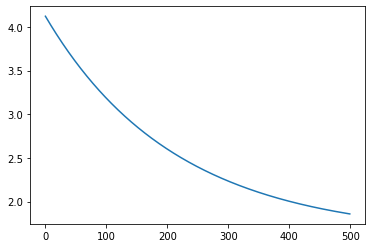

In [20]:
plt.plot(np.arange(num_iter),mselist2)

In [21]:
index2 = np.where(mselist2==np.min(mselist2))[0]
print(index2[0])
best_theta2 = theta_per_iter2[index2[0]]

499


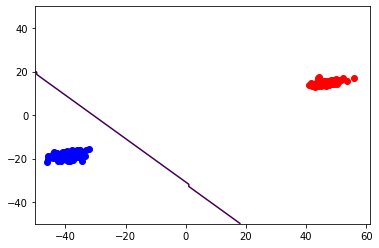

In [22]:
xlist = np.linspace(-50.0, 50.0, 100)
ylist = np.linspace(-50.0, 50.0, 100)
X, Y = np.meshgrid(xlist, ylist)
xplot = np.append(np.expand_dims(np.ones(X.ravel().shape),axis=1),np.expand_dims(X.ravel(),axis=1), axis=1)
xplot = np.append(xplot,np.expand_dims(Y.ravel(), axis=1), axis=1)
Z = Predict(xplot,best_theta2)
plt.contour(X,Y,Z[1].reshape(X.shape), levels=[0])
plt.scatter(gentoo.iloc[:,0], gentoo.iloc[:,1],color='red')
plt.scatter(adelie.iloc[:,0], adelie.iloc[:,1],color='blue')

# Part b

In [23]:
alpha = np.arange(0.01, 0.99, 0.04)
alphalist = list()
num_iter = 100
for a in alpha:
    theta1, h_of_x1, mse1, mselist1, theta_per_iter1 = Train(a, num_iter, x_train1, y_train1, 'gradientdescent')
    h_of_x_p1, y_pred1 = Predict( x_test1, theta1)
    mse1 = ComputeCost(y_test1, h_of_x_p1)
    acc1 = accuracy(y_test1, y_pred1)
    alphalist.append(mselist1)
    print("Test Mean Squared Error: ", mse1)
    print("Test Accuracy: ", acc1)

Theta:  [[0.61097821]
 [0.57451158]
 [0.5632928 ]]
Train Mean Squared Error:  1.8661943304123894
Test Mean Squared Error:  1.0802503192127855
Test Accuracy:  1.0
Theta:  [[0.79170318]
 [0.19331308]
 [0.17716374]]
Train Mean Squared Error:  1.940401317896489
Test Mean Squared Error:  0.9515084325151406
Test Accuracy:  1.0
Theta:  [[0.92068798]
 [0.07889947]
 [0.06201133]]
Train Mean Squared Error:  2.178116603543837
Test Mean Squared Error:  1.075755304316776
Test Accuracy:  1.0
Theta:  [[0.97016015]
 [0.03517519]
 [0.01802518]]
Train Mean Squared Error:  2.2747768295381308
Test Mean Squared Error:  1.12839387895172
Test Accuracy:  1.0
Theta:  [[0.98891325]
 [0.01859165]
 [0.00136101]]
Train Mean Squared Error:  2.312199153124622
Test Mean Squared Error:  1.1490598967869956
Test Accuracy:  1.0
Theta:  [[ 0.9959539 ]
 [ 0.01235602]
 [-0.00488616]]
Train Mean Squared Error:  2.326360086662249
Test Mean Squared Error:  1.1569197128782807
Test Accuracy:  1.0
Theta:  [[ 0.99857144]
 [ 0.0100

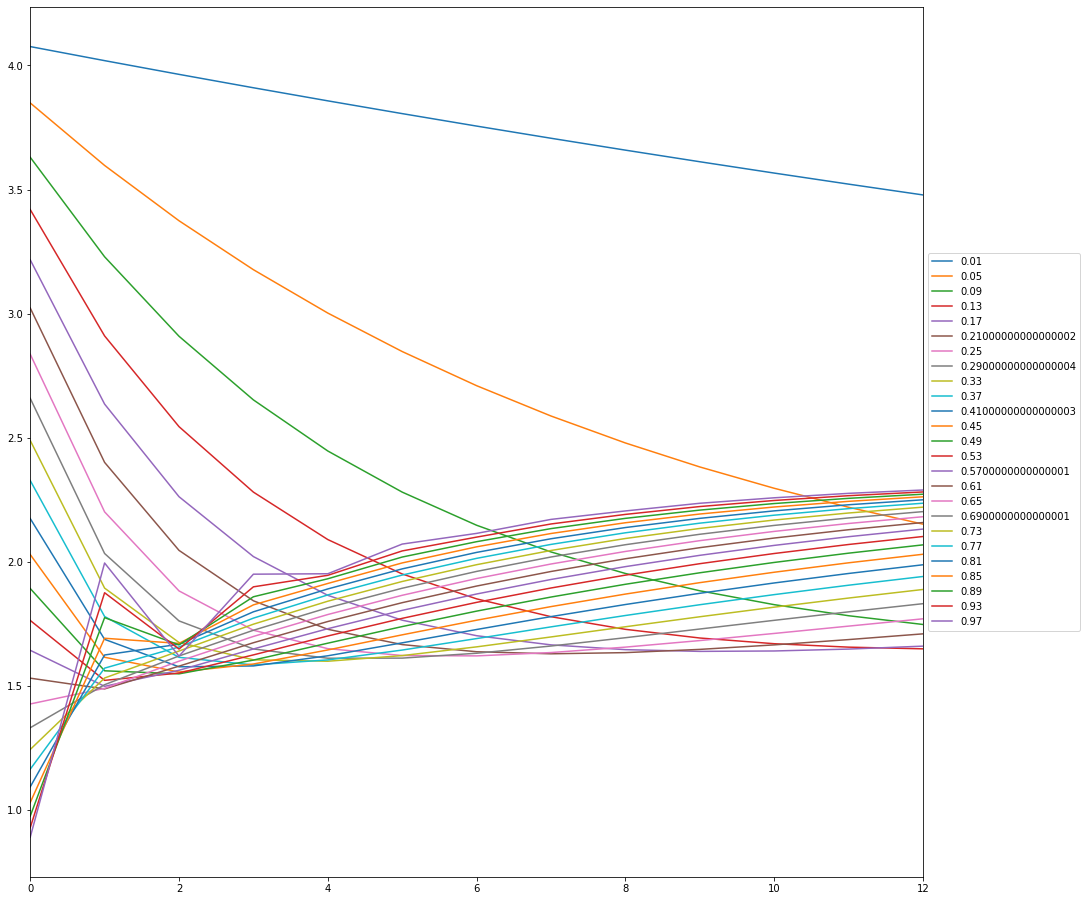

In [24]:
plt.figure(figsize=(16,16))
for i in range(len(alphalist)):
    plt.plot(np.arange(num_iter),alphalist[i],label=alpha[i])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlim((0,12))
plt.show()